<a href="https://colab.research.google.com/github/JoshDumo/histopathology/blob/main/Onco_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.4.1


Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteDKYI6R/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
Label: 6


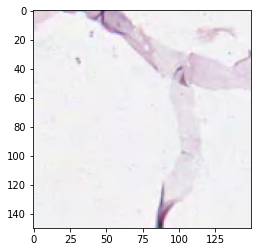

In [3]:
# EXTRACT

test_ds = tfds.load(name="colorectal_histology", 
                   split="train[0%:10%]",
                   shuffle_files=True,
                   as_supervised=True)

val_ds = tfds.load(name="colorectal_histology", 
                   split="train[10%:30%]",
                   shuffle_files=True,
                   as_supervised=True)

train_ds = tfds.load(name="colorectal_histology", 
                     split="train[-70%:]", 
                     shuffle_files=True, 
                     as_supervised=True)




# TRANSFORM
#train_ds.shuffle(100).batch(32).prefetch(tf.data.AUTOTUNE)

# LOAD
for data in train_ds.take(1):
    image = data[0].numpy().squeeze()
    label = data[1].numpy()
    
    print("Label: {}".format(label))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.show()


In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label


In [5]:
tds = train_ds.as_numpy_iterator()
labs = []
for el in tds:
  labs.append(el[1])

lab_cnt = []
for i in range(0,8):
  lab_cnt.append(labs.count(i))
lab_cnt
lab_list = ['Tumor', 'Stroma','Complex', 'Lympho','Debris','Mucosa','Adipose','Empty']

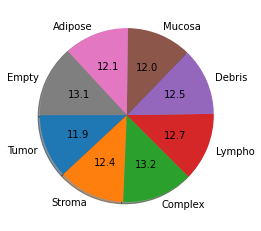

<Figure size 1152x1152 with 0 Axes>

In [6]:
plt.pie(lab_cnt, labels=['Tumor', 'Stroma','Complex', 'Lympho','Debris','Mucosa','Adipose','Empty'], startangle=180, 
        autopct='%1.1f', shadow=True)
plt.figure(figsize=(16,16))
plt.show()

In [7]:
test_lb = test_ds.as_numpy_iterator()
test_labels = []
for tlb in test_lb:
  test_labels.append(tlb[1])

In [8]:
train_ds = train_ds.map(normalize_img,
                        num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)

In [9]:
val_ds = val_ds.map(normalize_img,
                    num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(128).cache().prefetch(tf.data.AUTOTUNE)

In [10]:
test_ds = test_ds.map(normalize_img,
                    num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(128).cache().prefetch(tf.data.AUTOTUNE)

In [11]:
val_ds.enumerate()

<ZipDataset shapes: ((), ((None, 150, 150, 3), (None,))), types: (tf.int64, (tf.float32, tf.int64))>

In [12]:
train_ds

<PrefetchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>

In [13]:
test_ds

<PrefetchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>

In [14]:
kernel_size = (3,3)
pool_size= (2,2)

zeroth_filters = 16
first_filters = 64
second_filters = 256
third_filters = 1024

dropout_conv = 0.3
dropout_dense = 0.3


model = tf.keras.models.Sequential([
                                    layers.Conv2D(zeroth_filters, kernel_size, padding='same',activation = 'relu', input_shape = (150, 150, 3)),
                                    #layers.Conv2D(zeroth_filters, kernel_size, activation = 'relu'),
                                    #layers.Conv2D(zeroth_filters, kernel_size, activation = 'relu'),
                                    layers.MaxPooling2D(pool_size = pool_size),
                                    #layers.Dropout(dropout_conv),
                                    layers.Conv2D(first_filters, kernel_size, activation = 'relu'),
                                    #layers.Conv2D(first_filters, kernel_size, activation = 'relu'),
                                    #layers.Conv2D(first_filters, kernel_size, activation = 'relu'),
                                    layers.MaxPooling2D(pool_size = pool_size),
                                    #layers.Dropout(dropout_conv),
                                    layers.Conv2D(second_filters, kernel_size, activation ='relu'),
                                    #layers.Conv2D(second_filters, kernel_size, activation ='relu'),
                                    #layers.Conv2D(second_filters, kernel_size, activation ='relu'),
                                    layers.MaxPooling2D(pool_size = pool_size),
                                    #layers.Dropout(dropout_conv),
                                    layers.Conv2D(third_filters, kernel_size, activation ='relu'),
                                    #layers.Conv2D(third_filters, kernel_size, activation ='relu'),
                                    #layers.Conv2D(third_filters, kernel_size, activation ='relu'),
                                    layers.MaxPooling2D(pool_size = pool_size),
                                    #layers.Dropout(dropout_conv),
                                    layers.Flatten(),
                                    layers.Dense(256, activation = "relu"),
                                    #layers.Dropout(dropout_dense),
                                    layers.Dense(8, activation = "softmax")
                                    
])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 256)       147712    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 1024)      2

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


In [16]:
filepath = "model2.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_sparse_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=40, verbose=1,
                   callbacks=callbacks_list)


Epoch 1/40
28/28 [==============================] - 15s 228ms/step - loss: 2.3276 - sparse_categorical_accuracy: 0.1846 - val_loss: 1.1629 - val_sparse_categorical_accuracy: 0.4410

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.44100, saving model to model2.h5
Epoch 2/40
28/28 [==============================] - 4s 129ms/step - loss: 1.1204 - sparse_categorical_accuracy: 0.4980 - val_loss: 0.8804 - val_sparse_categorical_accuracy: 0.6290

Epoch 00002: val_sparse_categorical_accuracy improved from 0.44100 to 0.62900, saving model to model2.h5
Epoch 3/40
28/28 [==============================] - 4s 131ms/step - loss: 0.9981 - sparse_categorical_accuracy: 0.5861 - val_loss: 0.8397 - val_sparse_categorical_accuracy: 0.6120

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.62900
Epoch 4/40
28/28 [==============================] - 4s 131ms/step - loss: 0.8466 - sparse_categorical_accuracy: 0.6552 - val_loss: 0.7918 - val_sparse_categorical_accuracy: 0.

In [17]:
val_loss, val_acc = model.evaluate(test_ds)

4/4 [==============================] - 1s 342ms/step - loss: 0.4733 - sparse_categorical_accuracy: 0.8420


In [18]:
val_loss, val_acc

(0.47330406308174133, 0.8420000076293945)

<Figure size 432x288 with 0 Axes>

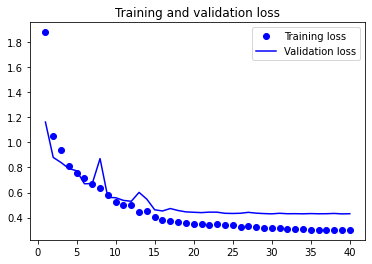

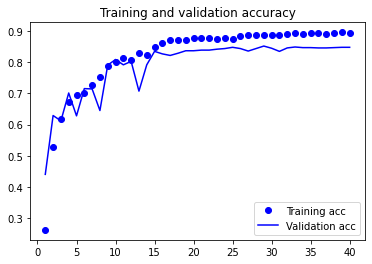

<Figure size 432x288 with 0 Axes>

In [19]:

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


In [20]:
predictions = model.predict(test_ds)

In [21]:
predictions.shape

(500, 8)

In [22]:
preds_ds = pd.DataFrame(predictions, columns=lab_list)
preds_ds.head()

,Tumor,Stroma,Complex,Lympho,Debris,Mucosa,Adipose,Empty
0,0.000788,5.162182e-01,0.006981,7.599311e-06,4.759818e-01,0.000009,1.462200e-05,7.266965e-10
1,0.008838,8.880385e-02,0.164093,1.112836e-02,3.326721e-02,0.693869,1.011338e-06,1.468269e-17
2,0.923829,2.782822e-11,0.006752,1.144900e-02,4.882143e-07,0.057969,1.712630e-11,9.872404e-25
3,0.999863,1.765861e-15,0.000092,1.971822e-05,1.714885e-10,0.000025,2.178781e-14,5.921720e-28
4,0.000580,6.240563e-04,0.000074,1.312316e-07,5.427587e-02,0.000782,9.436640e-01,2.149793e-07


In [23]:
from sklearn.metrics import roc_auc_score

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

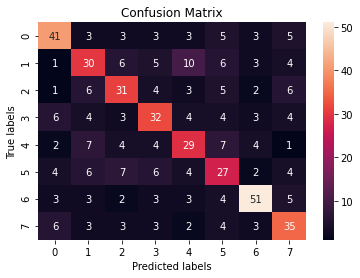

In [24]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [25]:
baseline_im = tf.zeros(shape=(150,150,3))


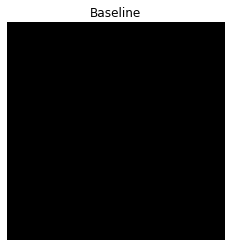

In [26]:
plt.imshow(baseline_im)
plt.title("Baseline")
plt.axis('off')
plt.show()


In [27]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.


In [28]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [31]:
for data in test_ds.take(1):
    test_im = data[0].numpy().squeeze()
    interpolate_images(
    baseline=baseline_im,
    image=test_im,
    alphas=alphas)
    


InvalidArgumentError: ignored

In [30]:
interpolated_images = interpolate_images(
    baseline=baseline_im,
    image=img_name_tensors['Fireboat'],
    alphas=alphas)


NameError: ignored